In [1]:
import matplotlib.pyplot as plt
import torch
import plenoptic as po
from utils import *
import glob
from os.path import join, exists
import numpy as np

# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams["figure.dpi"] = 72

%matplotlib inline

plt.rcParams["animation.html"] = "html5"
# use single-threaded ffmpeg for animation writer
plt.rcParams["animation.writer"] = "ffmpeg"
plt.rcParams["animation.ffmpeg_args"] = ["-threads", "1"]

# this notebook runs just about as fast with GPU and CPU
device = torch.device("cpu")
#device = torch.device(f"cuda:6")

In [2]:
model = load_model('dino_ego4d-200h_vitb14') # load model
model.to(device)
model.eval()

globimages = glob.glob('testsets/' + 'MEG_face_stim' + '/*.jpg')
globimages.sort()
imgp = globimages[0] # pick up first image as a test
img = preprocess_image(imgp, 224).to(device)
img = img.unsqueeze(0) # add a batch layer
with torch.no_grad():
    out = model(img)


Take key teacher in provided checkpoint dict
Pretrained weights found at /data/alban/models/huggingface_hub/models--eminorhan--dino_ego4d-200h_vitb14/snapshots/6222b6a14c40a4dad7d935460da8226a90c7d225/dino_ego4d-200h_vitb14.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [3]:
out.shape

torch.Size([1, 768])

/home/alban/DeepVis/lib/python3.10/site-packages/plenoptic/tools/validate.py:243: UserWarning: plenoptic's methods have mostly been tested on models which produce 3d or 4d outputs. They should theoretically work with different dimensionality; if you have any problems, please open an issue at https://github.com/plenoptic-org/plenoptic/issues/new?template=bug_report.md
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: xlabel='Synthesis iteration', ylabel='Loss'>

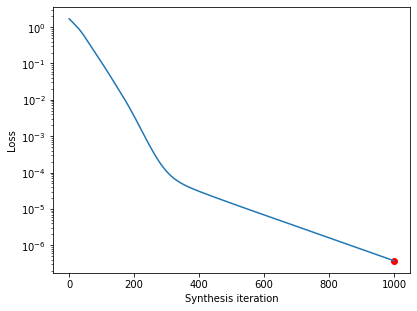

In [4]:
po.tools.remove_grad(model)

metamer = po.synth.Metamer(img, model, allowed_range=(-5,5))

matched_im = metamer.synthesize(store_progress=True, max_iter=1000, stop_criterion=1e-10)
po.synth.metamer.plot_loss(metamer)

In [5]:
def convert2display(img):
    ### assumes the iamge shapoe is (1,3,h, w)
    img = img.detach().cpu().numpy()
    img = img.reshape(img.shape[1:])
    img = img.transpose(1, 2, 0)
    img = (img - np.min(img))/(np.max(img) - np.min(img))

    return img

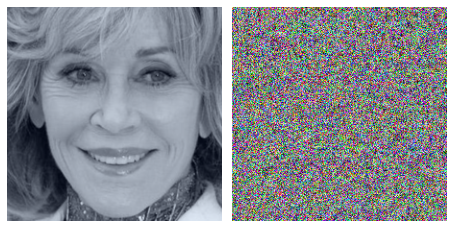

In [6]:
fig, subs = plt.subplots(nrows=1, ncols=2)
subs[0].imshow(convert2display(img))
subs[1].imshow(convert2display(metamer.metamer))
for sub in subs:
    sub.axis('off')
fig.tight_layout()
plt.show()

In [7]:
anim = po.synth.metamer.animate(metamer, included_plots=["display_metamer",
        "plot_loss"])
anim

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.0..5.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.0..5.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.0..5.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.0..5.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.0..5.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.0098915..5.0099893].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.009914..5.0099463].
Clipping input data to the valid range for ims

In [7]:
out_img = model(img)
out_metamer = model(metamer.metamer)
img1 = preprocess_image(imgp, 224)
cls_token= retrieve_tokens(model, img1, device = device)

print(np.mean(out_img.detach().cpu().numpy() - cls_token[-1])) # making sure that the outputs are the cls_tokens of the last layer
## Making sure the searched image is actually a metamer
diff = np.mean(np.absolute(out_img.detach().cpu().numpy() - out_metamer.detach().cpu().numpy()))
norm = np.mean(np.absolute(out_img.detach().cpu().numpy()) + np.absolute(out_metamer.detach().cpu().numpy()))/2
print(f'The normalized <<perceived>> difference between the 2 metamers is {diff/norm}')


0.0
The normalized <<perceived>> difference between the 2 metamers is 0.001220921752974391


In [20]:
print('What about for 2 iamges of the same category? ')

imgp2 = globimages[1]
print([imgp.split('/')[-1], imgp2.split('/')[-1]])
img2 = preprocess_image(imgp2, 224).to(device)
img2 = img2.unsqueeze(0) # add a batch layer

out_img2 = model(img2)

diff_samecat = np.mean(np.absolute(out_img.detach().cpu().numpy() - out_img2.detach().cpu().numpy()))
norm_samecat = np.mean(np.absolute(out_img.detach().cpu().numpy()) + np.absolute(out_img2.detach().cpu().numpy()))/2
print(f'The normalized <<perceived>> difference between 2 images of same category is {diff_samecat/norm_samecat}')

What about for 2 iamges of the same category? 
['f_o_f_1_1.jpg', 'f_o_f_1_2.jpg']
The normalized <<perceived>> difference between 2 images of same category is 0.6491450667381287


In [25]:
print('What about for 2 iamges of different categories? ')

imgp3 = globimages[70]
print([imgp.split('/')[-1], imgp3.split('/')[-1]])
img3 = preprocess_image(imgp3, 224).to(device)
img3 = img3.unsqueeze(0) # add a batch layer

out_img3 = model(img3)

diff_diffcat = np.mean(np.absolute(out_img.detach().cpu().numpy() - out_img3.detach().cpu().numpy()))
norm_diffcat = np.mean(np.absolute(out_img.detach().cpu().numpy()) + np.absolute(out_img3.detach().cpu().numpy()))/2
print(f'The normalized <<perceived>> difference between 2 images of different categories is {diff_diffcat/norm_diffcat}')

What about for 2 iamges of different categories? 
['f_o_f_1_1.jpg', 'm_y_u_1_1.jpg']
The normalized <<perceived>> difference between 2 images of different categories is 1.1467454433441162


It looks like the metamer method from a noise image is not working great. How about if we start from a generic face?

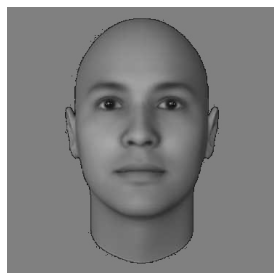

In [8]:
andro = preprocess_image('testsets/androgeneous_face_grey.jpg', 224).to(device)
andro = andro.unsqueeze(0) # add a batch layer
from PIL import Image
with open('testsets/androgeneous_face_grey.jpg', 'rb') as f:
    andro2dysp = Image.open(f)
    andro2dysp = andro2dysp.convert('RGB')
fig, subs = plt.subplots(nrows=1, ncols=1)
#subs.imshow(convert2display(andro))
subs.imshow(andro2dysp)
subs.axis('off')
plt.show()
plt.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: xlabel='Synthesis iteration', ylabel='Loss'>

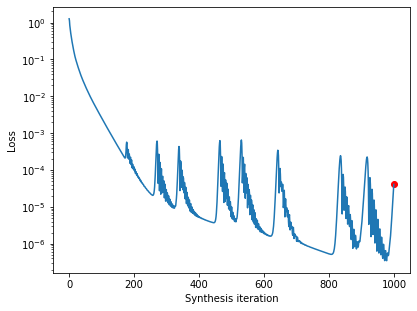

In [9]:
po.tools.remove_grad(model)
metamer2 = po.synth.Metamer(img, model, allowed_range=(-5,5))
metamer2.setup(initial_image = andro)
matched_im2 = metamer2.synthesize(store_progress=True, max_iter=1000, stop_criterion=1e-10)
po.synth.metamer.plot_loss(metamer2)

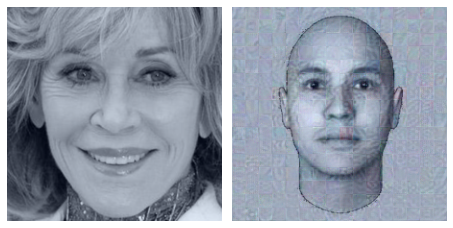

In [10]:
fig, subs = plt.subplots(nrows=1, ncols=2)
subs[0].imshow(convert2display(img), cmap = 'gray')
subs[1].imshow(convert2display(metamer2.metamer), cmap = 'gray')
for sub in subs:
    sub.axis('off')
fig.tight_layout()
plt.show()

In [11]:
anim = po.synth.metamer.animate(metamer2, included_plots=["display_metamer",
        "plot_loss"])
anim

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..1.1236603].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..1.1236603].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..1.1236603].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..1.1236603].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..1.1236603].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8681583..1.1336598].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.874099